## Data Prep

In [75]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [76]:
reversed_df = df.iloc[::-1]

In [77]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [78]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(df))

# Split data into forward and backward sets
X_fwd = df.values
y_fwd = df.iloc[:, 4].values  # target is at index 4

X_bkwd = reversed_df.values
y_bkwd = reversed_df.iloc[:, 4].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [79]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler_fwd = StandardScaler()
X_train_fwd_scaled = scaler_fwd.fit_transform(X_train_fwd)
X_test_fwd_scaled = scaler_fwd.transform(X_test_fwd)

scaler_bkwd = StandardScaler()
X_train_bkwd_scaled = scaler_bkwd.fit_transform(X_train_bkwd)
X_test_bkwd_scaled = scaler_bkwd.transform(X_test_bkwd)

In [80]:
# Check the mean and standard deviation of each feature
mean_values = np.mean(X_train_fwd_scaled, axis=0)
std_dev_values = np.std(X_train_fwd_scaled, axis=0)

# Print the mean and standard deviation for each feature
for i, (mean, std_dev) in enumerate(zip(mean_values, std_dev_values)):
    print(f"Feature {i+1}: Mean={mean}, Std Dev={std_dev}")

Feature 1: Mean=2.5994475299329147e-17, Std Dev=1.0
Feature 2: Mean=5.1988950598658294e-17, Std Dev=1.0
Feature 3: Mean=-2.5994475299329147e-17, Std Dev=1.0
Feature 4: Mean=2.5994475299329147e-17, Std Dev=0.9999999999999999
Feature 5: Mean=2.5994475299329147e-17, Std Dev=1.0
Feature 6: Mean=-9.747928237248431e-17, Std Dev=0.9999999999999999


In [81]:
# Create sequences for training data
seq_length = 5
prediction_length = 1
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd_scaled, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd_scaled, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd_scaled, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd_scaled, seq_length, prediction_length)

In [82]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

In [83]:
test_data_bkwd[:10]

(tensor([[[-0.5473, -0.5472, -0.5471, -0.5471, -0.5330, -0.5338],
          [-0.5476, -0.5475, -0.5474, -0.5473, -0.5331, -0.4915],
          [-0.5478, -0.5477, -0.5475, -0.5475, -0.5333, -0.5206],
          [-0.5479, -0.5479, -0.5477, -0.5477, -0.5335, -0.7204],
          [-0.5479, -0.5479, -0.5478, -0.5478, -0.5336, -0.6139]],
 
         [[-0.5476, -0.5475, -0.5474, -0.5473, -0.5331, -0.4915],
          [-0.5478, -0.5477, -0.5475, -0.5475, -0.5333, -0.5206],
          [-0.5479, -0.5479, -0.5477, -0.5477, -0.5335, -0.7204],
          [-0.5479, -0.5479, -0.5478, -0.5478, -0.5336, -0.6139],
          [-0.5480, -0.5480, -0.5478, -0.5478, -0.5336, -0.6912]],
 
         [[-0.5478, -0.5477, -0.5475, -0.5475, -0.5333, -0.5206],
          [-0.5479, -0.5479, -0.5477, -0.5477, -0.5335, -0.7204],
          [-0.5479, -0.5479, -0.5478, -0.5478, -0.5336, -0.6139],
          [-0.5480, -0.5480, -0.5478, -0.5478, -0.5336, -0.6912],
          [-0.5480, -0.5480, -0.5478, -0.5479, -0.5336, -0.6703]],
 
 

## Simple RNN

### Model Definition

In [95]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [96]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader, test_loader):
    train_loss_values = []
    test_loss_values = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
        
        # Testing phase
        model.eval() 
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels.unsqueeze(-1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_values.append(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')
        
    return train_loss_values, test_loss_values


### Forward and Backward Training

Running on CPU
Epoch [1/50], Train Loss: 0.0111
Epoch [1/50], Test Loss: 6.5577
Epoch [2/50], Train Loss: 0.0002
Epoch [2/50], Test Loss: 6.0638
Epoch [3/50], Train Loss: 0.0001
Epoch [3/50], Test Loss: 5.7428
Epoch [4/50], Train Loss: 0.0001
Epoch [4/50], Test Loss: 5.4815
Epoch [5/50], Train Loss: 0.0001
Epoch [5/50], Test Loss: 5.3218
Epoch [6/50], Train Loss: 0.0001
Epoch [6/50], Test Loss: 5.1814
Epoch [7/50], Train Loss: 0.0000
Epoch [7/50], Test Loss: 5.0671
Epoch [8/50], Train Loss: 0.0000
Epoch [8/50], Test Loss: 4.9976
Epoch [9/50], Train Loss: 0.0000
Epoch [9/50], Test Loss: 4.9368
Epoch [10/50], Train Loss: 0.0000
Epoch [10/50], Test Loss: 4.9089
Epoch [11/50], Train Loss: 0.0000
Epoch [11/50], Test Loss: 4.8808
Epoch [12/50], Train Loss: 0.0000
Epoch [12/50], Test Loss: 4.8511
Epoch [13/50], Train Loss: 0.0000
Epoch [13/50], Test Loss: 4.8310
Epoch [14/50], Train Loss: 0.0000
Epoch [14/50], Test Loss: 4.8049
Epoch [15/50], Train Loss: 0.0000
Epoch [15/50], Test Loss: 4.781

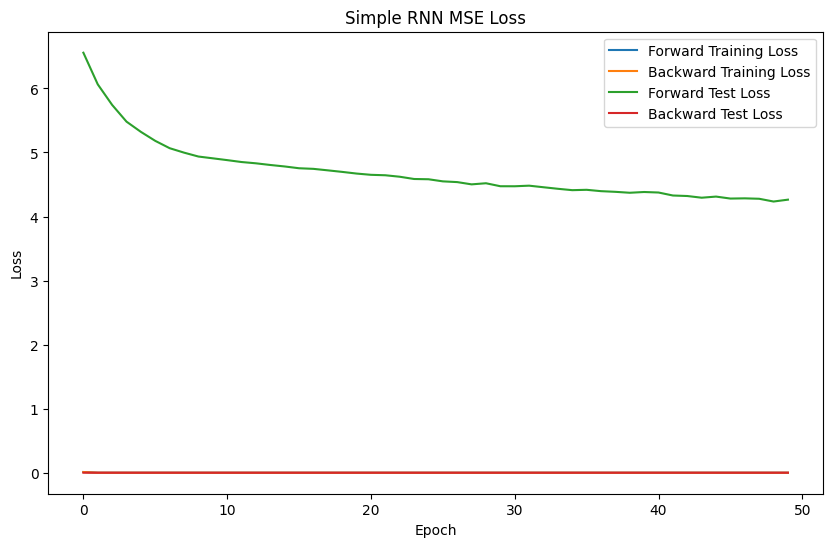

In [30]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 50

# Forward Model Initialization and Training 
model_fwd = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer_fwd = optim.Adam(model_fwd.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_fwd,
    criterion=criterion,
    model=model_fwd,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model_bkwd = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer_bkwd = optim.Adam(model_bkwd.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_bkwd,
    criterion=criterion,
    model=model_bkwd,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple RNN MSE Loss')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## LSTM

In [37]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/50], Train Loss: 0.2327
Epoch [1/50], Test Loss: 3.0108
Epoch [2/50], Train Loss: 0.0115
Epoch [2/50], Test Loss: 1.1141
Epoch [3/50], Train Loss: 0.0033
Epoch [3/50], Test Loss: 0.7645
Epoch [4/50], Train Loss: 0.0026
Epoch [4/50], Test Loss: 0.6825
Epoch [5/50], Train Loss: 0.0022
Epoch [5/50], Test Loss: 0.6204
Epoch [6/50], Train Loss: 0.0021
Epoch [6/50], Test Loss: 0.5777
Epoch [7/50], Train Loss: 0.0018
Epoch [7/50], Test Loss: 0.5487
Epoch [8/50], Train Loss: 0.0017
Epoch [8/50], Test Loss: 0.5528
Epoch [9/50], Train Loss: 0.0015
Epoch [9/50], Test Loss: 0.4624
Epoch [10/50], Train Loss: 0.0013
Epoch [10/50], Test Loss: 0.4342
Epoch [11/50], Train Loss: 0.0013
Epoch [11/50], Test Loss: 0.4373
Epoch [12/50], Train Loss: 0.0011
Epoch [12/50], Test Loss: 0.4120
Epoch [13/50], Train Loss: 0.0010
Epoch [13/50], Test Loss: 0.3988
Epoch [14/50], Train Loss: 0.0009
Epoch [14/50], Test Loss: 0.3985
Epoch [15/50], Train Loss: 0.0009
Epoch [15/50], Test Loss: 0.3832
Epoch [16/50]

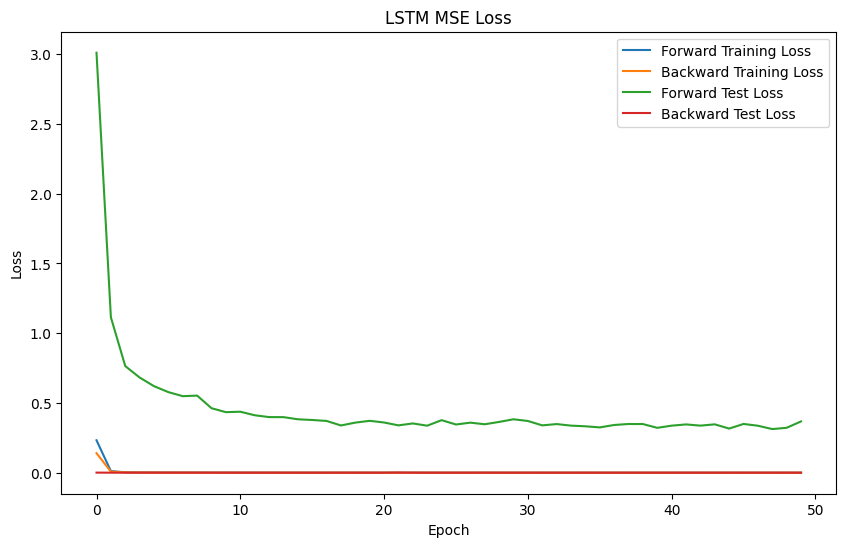

In [46]:
# LSTM Model Initialization and Training 

#Forward
lstm_model = LSTMModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_fwd, 
    test_loader=test_loader_fwd     
)

#Backward
lstm_model = LSTMModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_bkwd, 
    test_loader=test_loader_bkwd
)  

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM MSE Loss')
plt.legend()
plt.show()

## GRU

In [39]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/50], Train Loss: 0.2060
Epoch [1/50], Test Loss: 3.2570
Epoch [2/50], Train Loss: 0.0157
Epoch [2/50], Test Loss: 1.9052
Epoch [3/50], Train Loss: 0.0066
Epoch [3/50], Test Loss: 1.2852
Epoch [4/50], Train Loss: 0.0037
Epoch [4/50], Test Loss: 0.9647
Epoch [5/50], Train Loss: 0.0027
Epoch [5/50], Test Loss: 0.8407
Epoch [6/50], Train Loss: 0.0024
Epoch [6/50], Test Loss: 0.7339
Epoch [7/50], Train Loss: 0.0020
Epoch [7/50], Test Loss: 0.7134
Epoch [8/50], Train Loss: 0.0017
Epoch [8/50], Test Loss: 0.6638
Epoch [9/50], Train Loss: 0.0016
Epoch [9/50], Test Loss: 0.6103
Epoch [10/50], Train Loss: 0.0013
Epoch [10/50], Test Loss: 0.5557
Epoch [11/50], Train Loss: 0.0012
Epoch [11/50], Test Loss: 0.5112
Epoch [12/50], Train Loss: 0.0010
Epoch [12/50], Test Loss: 0.4988
Epoch [13/50], Train Loss: 0.0009
Epoch [13/50], Test Loss: 0.4671
Epoch [14/50], Train Loss: 0.0008
Epoch [14/50], Test Loss: 0.4426
Epoch [15/50], Train Loss: 0.0008
Epoch [15/50], Test Loss: 0.4303
Epoch [16/50]

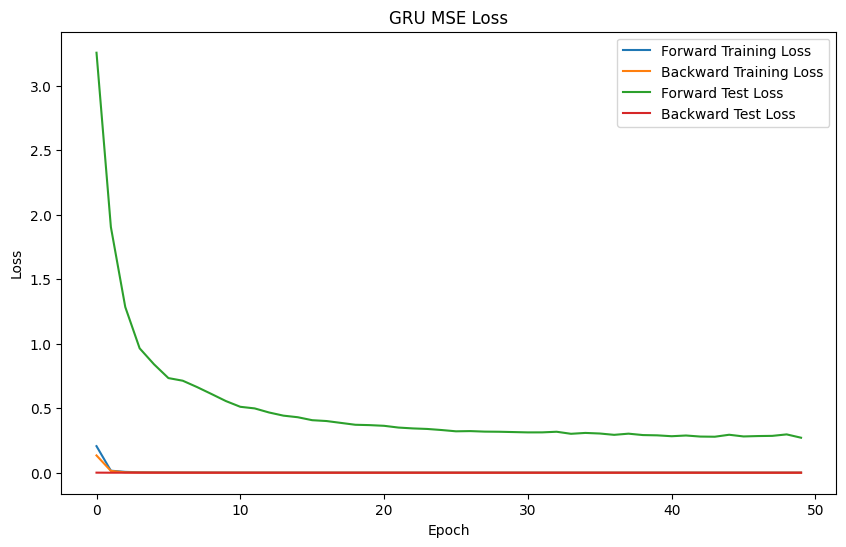

In [47]:
# LSTM Model Initialization and Training 

#Forward
lstm_model = GRUModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_fwd, 
    test_loader=test_loader_fwd     
)

#Backward
lstm_model = GRUModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_bkwd, 
    test_loader=test_loader_bkwd
)  

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU MSE Loss')
plt.legend()
plt.show()

## Transformer

### Model Definition

In [41]:
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size) 
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [42]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2
num_epochs = 50

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/christopherguarino/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_test_loss += val_loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss) 
        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses 


In [44]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

### Forward and Backward Training

Epoch [1/50]: Train Loss: 0.3441, Test Loss: 5.6168
Epoch [2/50]: Train Loss: 0.1367, Test Loss: 5.3034
Epoch [3/50]: Train Loss: 0.1153, Test Loss: 4.7158
Epoch [4/50]: Train Loss: 0.1007, Test Loss: 4.1093
Epoch [5/50]: Train Loss: 0.0932, Test Loss: 3.6944
Epoch [6/50]: Train Loss: 0.0853, Test Loss: 3.2938
Epoch [7/50]: Train Loss: 0.0811, Test Loss: 3.0948
Epoch [8/50]: Train Loss: 0.0777, Test Loss: 2.7669
Epoch [9/50]: Train Loss: 0.0728, Test Loss: 2.6768
Epoch [10/50]: Train Loss: 0.0692, Test Loss: 2.3246
Epoch [11/50]: Train Loss: 0.0637, Test Loss: 2.1829
Epoch [12/50]: Train Loss: 0.0591, Test Loss: 1.8985
Epoch [13/50]: Train Loss: 0.0563, Test Loss: 1.6340
Epoch [14/50]: Train Loss: 0.0531, Test Loss: 1.4834
Epoch [15/50]: Train Loss: 0.0529, Test Loss: 1.5426
Epoch [16/50]: Train Loss: 0.0493, Test Loss: 1.3614
Epoch [17/50]: Train Loss: 0.0439, Test Loss: 1.3131
Epoch [18/50]: Train Loss: 0.0432, Test Loss: 1.2125
Epoch [19/50]: Train Loss: 0.0374, Test Loss: 1.1701
Ep

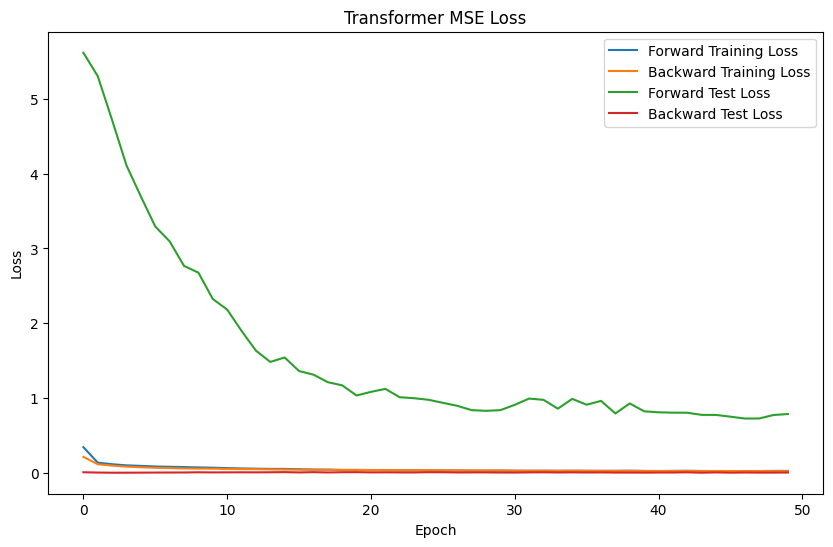

In [45]:
import matplotlib.pyplot as plt

model.apply(reset_weights) 
loss_values_fwd_train, loss_values_fwd_test = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs)
model.apply(reset_weights) 
loss_values_bkwd_train, loss_values_bkwd_test = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer MSE Loss')
plt.legend()
plt.show()


### Thoughts
You know what I am struggling with. Becasue this time series data is heavily influenced by macro economics, so when you split the data the is a chance that oyu are splitting it around a pivotal moment in the stock's life. So how do you knwo if the testing evaluation is representative of the overall trends. This could explain why the data running backward is testing well where as the loss on the forward running data is very high. 

## Key Takeaways from the Experiment:

### Model Performance:
- All models show a sharp decrease in loss initially, indicating that they are learning from the data. However, the Transformer shows a more erratic decrease, which might be due to its sensitivity to the sequence length or the hyperparameters chosen.

### Training vs Testing Loss:
- For Simple RNN, LSTM, and GRU models, training losses decrease and plateau, which is typical behavior as models converge. Test losses remain stable after the initial decrease, which suggests the models are generalizing well and not overfitting. However, the Transformer model's test loss seems to be more variable and doesn't settle as much as the others, which might be indicative of overfitting or a requirement for more tuning.

### Backward vs Forward Training:
- There's a noticeable discrepancy between forward and backward predictions. Generally, the test losses for backward runs are lower than for forward runs, which could imply that learning from the most recent data (when running backward) might be more beneficial for the model due to data non-stationarity, changes in market behavior, or different volatility regimes.

### Predictive Power and Overfitting:
- The RNN-based models appear to learn well without overfitting, as indicated by the closeness of training and test losses. The Transformer's performance may suggest it's overfitting, or it might need more training epochs or adjustments in its architecture, such as layers or attention heads.

### Time Series Split Concerns:
- Your concern about splitting data at pivotal moments is valid. Time series data, especially stocks, can have significant regime changes due to macroeconomic factors, market cycles, or company-specific events. These changes can drastically affect the model's learning and prediction accuracy.

### Representativeness of Test Data:
- If the test data contains periods of high volatility or trend shifts not seen in the training data, the model may perform poorly. Conversely, if the test data is too similar to the training data, it may not challenge the model sufficiently.

## GPT Suggestions for Improvement:

### Cross-Validation:
- Instead of a single train-test split, consider using time series cross-validation. This technique rolls or expands the training data and can help assess how well the model might perform at different times, increasing confidence in its predictive power.

### Regime Detection:
- Introduce regime detection mechanisms to identify shifts in the data distribution and adjust the model or training data accordingly.

### Hyperparameter Tuning:
- Experiment with hyperparameter tuning, especially for the Transformer model, as it might be more sensitive to these settings compared to RNN-based models.

### External Data:
- Incorporate external data or features that could account for the macroeconomic factors influencing stock prices.

### Model Complexity:
- Given the relative simplicity of the time series (single-variable, stock prices), consider if the complexity of Transformers is necessary, or if simpler models like GRU or LSTM are sufficient.

### Backtesting:
- Use backtesting to evaluate the model's performance over different historical periods and market conditions.

## Conclusion:

The experiment suggests RNN-based models like LSTM and GRU may be more suitable for this type of time series forecasting than the more complex Transformer model. The training and evaluation methodology plays a crucial role in assessing model performance, especially in the context of time series data that can undergo significant shifts. It's also clear that while learning from recent data can sometimes give better results (as seen in the backward runs), a robust model should perform well over both recent and older data. Further experimentation with model architecture, hyperparameters, and training methodology could lead to more definitive conclusions.


Ideas: 
- use the models to predict on new data. 

### Sine Data to Troubleshoot

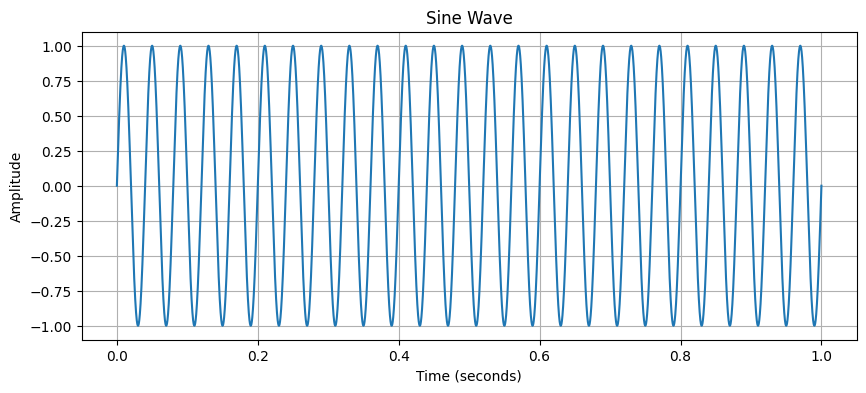

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
amplitude = 1       # Amplitude of the sine wave
frequency = 25      # Frequency of the sine wave
num_points = 10000  # Number of data points
duration = 1       # Duration in seconds over which the sine wave spans

# Generate time array (x values) from 0 to duration
x = np.linspace(0, duration, num_points)

# Generate Sine Wave, adjusting the formula to fit the frequency and duration
y = amplitude * np.sin(2 * np.pi * frequency * x / duration)

# Create DataFrame
sine_data = pd.DataFrame({
    'Time': x,
    'Amplitude': y
})

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(data['Time'], data['Amplitude'])
plt.title('Sine Wave')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



In [74]:
sine_data

,Time,Amplitude
0,0.0000,0.000000e+00
1,0.0001,1.570889e-02
2,0.0002,3.141390e-02
3,0.0003,4.711116e-02
4,0.0004,6.279679e-02
...,...,...
9995,0.9996,-6.279679e-02
9996,0.9997,-4.711116e-02
9997,0.9998,-3.141390e-02
9998,0.9999,-1.570889e-02


In [85]:
reversed_sine_data = sine_data.iloc[::-1]
reversed_sine_data

,Time,Amplitude
9999,1.0000,9.821934e-16
9998,0.9999,-1.570889e-02
9997,0.9998,-3.141390e-02
9996,0.9997,-4.711116e-02
9995,0.9996,-6.279679e-02
...,...,...
4,0.0004,6.279679e-02
3,0.0003,4.711116e-02
2,0.0002,3.141390e-02
1,0.0001,1.570889e-02


In [90]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(sine_data))

# Split data into forward and backward sets
X_fwd = sine_data.values
y_fwd = sine_data.iloc[:, 1].values  # target is at index 4

X_bkwd = reversed_sine_data.values
y_bkwd = reversed_sine_data.iloc[:, 1].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [92]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][1]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [93]:
# Create sequences for training data
seq_length = 5
prediction_length = 1
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd, seq_length, prediction_length)

In [94]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

Running on CPU
Epoch [1/10], Train Loss: 0.0789
Epoch [1/10], Test Loss: 0.0025
Epoch [2/10], Train Loss: 0.0024
Epoch [2/10], Test Loss: 0.0021
Epoch [3/10], Train Loss: 0.0019
Epoch [3/10], Test Loss: 0.0018
Epoch [4/10], Train Loss: 0.0016
Epoch [4/10], Test Loss: 0.0016
Epoch [5/10], Train Loss: 0.0013
Epoch [5/10], Test Loss: 0.0014
Epoch [6/10], Train Loss: 0.0012
Epoch [6/10], Test Loss: 0.0011
Epoch [7/10], Train Loss: 0.0010
Epoch [7/10], Test Loss: 0.0009
Epoch [8/10], Train Loss: 0.0009
Epoch [8/10], Test Loss: 0.0008
Epoch [9/10], Train Loss: 0.0007
Epoch [9/10], Test Loss: 0.0007
Epoch [10/10], Train Loss: 0.0006
Epoch [10/10], Test Loss: 0.0005
Epoch [1/10], Train Loss: 0.1490
Epoch [1/10], Test Loss: 0.0036
Epoch [2/10], Train Loss: 0.0027
Epoch [2/10], Test Loss: 0.0025
Epoch [3/10], Train Loss: 0.0023
Epoch [3/10], Test Loss: 0.0021
Epoch [4/10], Train Loss: 0.0020
Epoch [4/10], Test Loss: 0.0018
Epoch [5/10], Train Loss: 0.0017
Epoch [5/10], Test Loss: 0.0016
Epoch [6

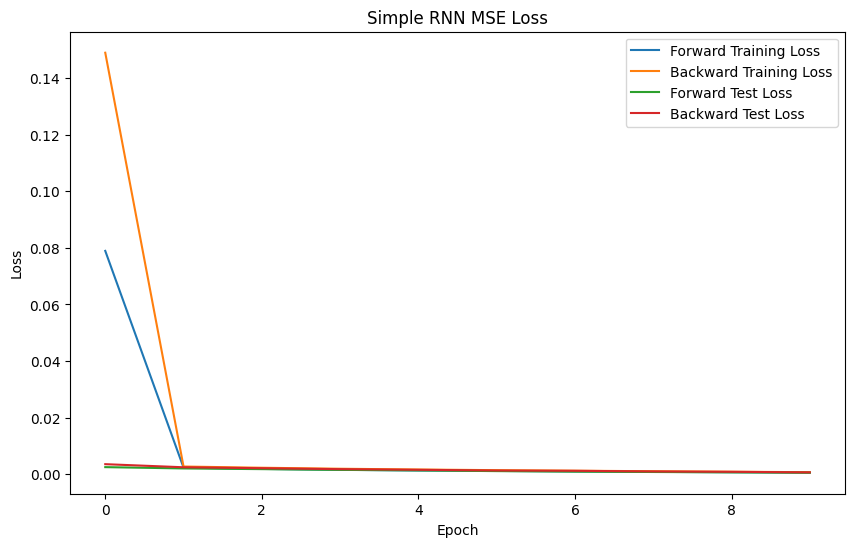

In [100]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 10

# Forward Model Initialization and Training 
model_fwd = SimpleRNN(input_size=2, hidden_size=20, output_size=1).to(device)
optimizer_fwd = optim.Adam(model_fwd.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_fwd,
    criterion=criterion,
    model=model_fwd,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model_bkwd = SimpleRNN(input_size=2, hidden_size=20, output_size=1).to(device)
optimizer_bkwd = optim.Adam(model_bkwd.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_bkwd,
    criterion=criterion,
    model=model_bkwd,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple RNN MSE Loss')
plt.legend()
plt.show()